Restarted .venv (Python 3.10.7)

 <div style="text-align: right">   </div>
 Introduction to Deep Learning (2024)

 **Assignment 2 - Sequence processing using RNNs**
 <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">

 # Introduction

 The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs).
 Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

 <img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

 In this assignment you will be working with three different kinds of models, based on input/output data modalities:

 1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation

 2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.

 3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.

 ### Description

 Let us suppose that we want to develop a neural network that learns how to add or subtract

 two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or

 ’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a

 sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,

 we want to build a model that generalizes well - if the network can extract the underlying principles behind

 the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate

 valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),

 2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.

 The example above describes a text-to-text sequence mapping scenario. However, we can also use different

 modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit

 dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

 *To work on this notebook you should create a copy of it.*


 # Function definitions for creating the datasets

 First we need to create our datasets that are going to be used for training our models.

 In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library.
 We will use these operand signs together with the MNIST dataset to represent the digits.

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, LSTM, Flatten, TimeDistributed # type: ignore
from tensorflow.keras.layers import RepeatVector, Conv2D, ConvLSTM2D # type: ignore

2024-12-12 23:42:21.584182: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 23:42:21.607777: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 23:42:21.607794: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 23:42:21.608590: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 23:42:21.612547: I tensorflow/core/platform/cpu_feature_guar

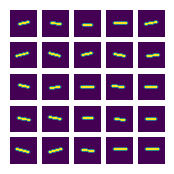

In [ ]:
from scipy.ndimage import rotate


# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):
    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images


def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())

In [ ]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:
    
    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=False)
                query_image = []

                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=False)
                result_image = []
                
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())
                    
                X_text.append(query_string)
                X_img.append(np.stack(query_image))

                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '

    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)

 # Creating our data

 The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

   **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]
   **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

   **y_text**: strings containing answers of length 3: ['  2', '156']
   **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #8224

X_text: "41+12" = y_text: " 53"


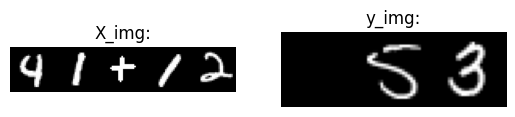

Query #2557

X_text: "12-78" = y_text: "-66"


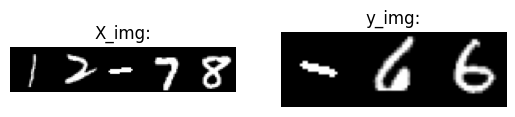

In [ ]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)

## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
        
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(2):
    display_sample(np.random.randint(0, 10000, 1)[0])

 ## Helper functions



 The functions below will help with input/output of the data.

In [ ]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs

# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
    n = len(labels)
    length = len(labels[0])
    char_map = dict(zip(unique_characters, range(len(unique_characters))))
    one_hot = np.zeros([n, length, len(unique_characters)])
    
    for i, label in enumerate(labels):
        m = np.zeros([length, len(unique_characters)])
        for j, char in enumerate(label):
            m[j, char_map[char]] = 1
        one_hot[i] = m

    return one_hot

def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])
    
    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)



 ## II. Image to text RNN Model

 Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells (with flattened images as input vectors) or
 recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

 The goal here is to use **X_img** as inputs and **y_text** as outputs.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_img, y_text_onehot, test_size=0.20, random_state=42) 
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42) 

-70


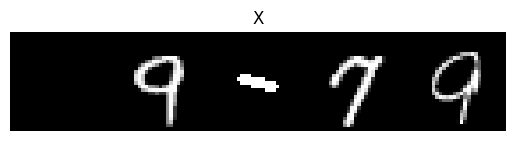

In [ ]:
print(decode_labels(y_test[0]))

plt.imshow(np.hstack(X_test[0]), cmap='gray')  # Display the frame in grayscale
plt.title(f"X")
plt.axis("off")
plt.show()

In [ ]:
## Your code
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, ConvLSTM2D,MaxPooling2D, BatchNormalization, Dropout,LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2


def build_img2text_model():
    # We start by initializing a sequential model
    img2text = keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. 
    # Each of these 5 elements in the query will be fed to the network one by one, as shown in the image above (except with 5 elements).

    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).

    img2text.add(
        ConvLSTM2D(filters=16,
        kernel_size=(3, 3),
        padding="same",
        return_sequences=True,
        activation="relu", 
        input_shape=(5, 28, 28, 1), 
        kernel_regularizer=l2(0.01))
    )
    img2text.add(BatchNormalization())
    img2text.add(Dropout(0.2))
    
    img2text.add(
        ConvLSTM2D(filters=32,
        kernel_size=(3, 3),
        padding="same",
        return_sequences=True,
        activation="relu", 
        kernel_regularizer=l2(0.01))
    )
    img2text.add(BatchNormalization())

    #img2text.add(Flatten())
    img2text.add(TimeDistributed(GlobalAveragePooling2D()))
    img2text.add(Dense(256, activation='relu'))
    img2text.add(Dropout(0.2))
    
    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    img2text.add(GlobalAveragePooling1D())
    img2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). 
    # This is necessary as TimeDistributed in the below expects the first dimension to be the timesteps.
    img2text.add(LSTM(128, return_sequences=True))
    img2text.add(LSTM(64, return_sequences=True))
    img2text.add(LayerNormalization())

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    img2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax',kernel_regularizer=l2(0.01))))

    # Next we compile the model using categorical crossentropy as our loss function.
    optimizer = Adam(learning_rate=0.001) 
    img2text.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    img2text.summary()

    return img2text

def build_img2text_model2():
    img2text = keras.Sequential()
    img2text.add(TimeDistributed(Conv2D(512, (3, 3), activation='relu'), input_shape=(5, 28, 28, 1)))
    img2text.add(TimeDistributed(MaxPooling2D((2, 2))))
    img2text.add(TimeDistributed(Dropout(0.2)))
    img2text.add(TimeDistributed(Flatten()))
    img2text.add(TimeDistributed(Dense(200, activation='relu')))
    img2text.add(LSTM(256, return_sequences=True))
    img2text.add(LSTM(256))
    
    img2text.add(RepeatVector(max_answer_length))
    img2text.add(LSTM(256, return_sequences=True))
    img2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))
    img2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    img2text.summary()

    return img2text

model = build_img2text_model2()

2024-12-12 23:42:45.500017: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-12 23:42:45.527539: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-12 23:42:45.527647: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 5, 26, 26, 512)    5120      
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 5, 13, 13, 512)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 5, 13, 13, 512)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 5, 86528)          0         
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 5, 200)            1

In [ ]:
import tensorflow.keras as keras
# Fit the model

checkpoint_cb = keras.callbacks.ModelCheckpoint(
        f"image_to_text_best.keras", save_best_only=True
    )
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=8,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size=32,
    epochs=100,
    callbacks = [checkpoint_cb, early_stopping, lr_scheduler]
)

Epoch 1/100


2024-12-12 23:42:51.980165: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/time_distributed_2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-12-12 23:42:52.149398: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-12-12 23:42:52.205096: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-12-12 23:42:52.424904: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-12 23:42:52.425153: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_b

500/500 [==============================] - 17s 29ms/step - loss: 1.8444 - accuracy: 0.2729 - val_loss: 1.7424 - val_accuracy: 0.3048 - lr: 0.0010
Epoch 2/100
500/500 [==============================] - 14s 28ms/step - loss: 1.6635 - accuracy: 0.3378 - val_loss: 1.5390 - val_accuracy: 0.4092 - lr: 0.0010
Epoch 3/100
500/500 [==============================] - 14s 28ms/step - loss: 1.4020 - accuracy: 0.4515 - val_loss: 1.2757 - val_accuracy: 0.4920 - lr: 0.0010
Epoch 4/100
500/500 [==============================] - 14s 28ms/step - loss: 1.1995 - accuracy: 0.5399 - val_loss: 1.2013 - val_accuracy: 0.5447 - lr: 0.0010
Epoch 5/100
500/500 [==============================] - 14s 28ms/step - loss: 1.0833 - accuracy: 0.5930 - val_loss: 1.0531 - val_accuracy: 0.6143 - lr: 0.0010
Epoch 6/100
500/500 [==============================] - 14s 28ms/step - loss: 0.9166 - accuracy: 0.6668 - val_loss: 0.8623 - val_accuracy: 0.7023 - lr: 0.0010
Epoch 7/100
500/500 [==============================] - 14s 28ms/

In [ ]:
model.save(f'submission1_image_to_text.keras')

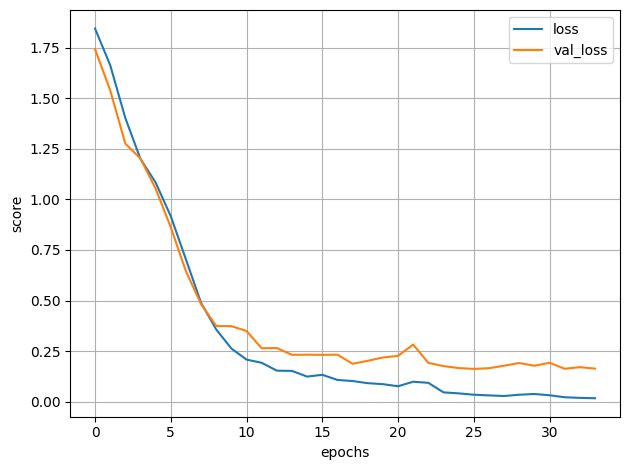

500/500 [==============================] - 4s 8ms/step - loss: 0.0287 - accuracy: 0.9942
Train Accuracy for text to text model: [0.028725819662213326, 0.9942499995231628]
63/63 [==============================] - 0s 8ms/step - loss: 0.1622 - accuracy: 0.9713
Test Accuracy for text to text model: [0.1621769666671753, 0.9713333249092102]


In [ ]:
import pandas as pd
data_history = pd.DataFrame(history.history)
data_history.to_csv('image_to_text_history.csv')

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epochs')
plt.ylabel('score')
plt.legend(loc="best")

plt.grid(True)
plt.tight_layout()
plt.show()

print("Train Accuracy for text to text model:", model.evaluate(X_train, y_train))
print("Test Accuracy for text to text model:", model.evaluate(X_test, y_test))

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
predictions = model.predict(X_test)
y_pred = [decode_labels(y) for y in predictions]
y_actual = [decode_labels(y) for y in y_test]
accuracy = accuracy_score(y_actual, y_pred)
print("Accuracy for image to text model:", accuracy)

63/63 [==============================] - 1s 6ms/step
Accuracy for image to text model: 0.9325


In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D,GlobalAveragePooling1D,ConvLSTM2D, BatchNormalization, Dropout,LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

def build_img2text_withConv():
    ## Your code
    # We start by initializing a sequential model
    img2text = keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.

    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,

    # as shown in the image above (except with 5 elements).

    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).

    img2text.add(
        TimeDistributed(
            Conv2D(
                filters=512,
                kernel_size=(3, 3),
                padding="same",
                return_sequences=True,
                activation="relu", 
                input_shape=(5, 28, 28, 1), 
                kernel_regularizer=l2(0.01)
            )
        )
    )
    img2text.add(TimeDistributed(GlobalAveragePooling2D()))
    img2text.add(BatchNormalization())
    img2text.add(Dropout(0.2))
 
    #img2text.add(Flatten())
    
    img2text.add(Dense(256, activation='relu'))
    img2text.add(Dropout(0.2))
    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')

    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    img2text.add(GlobalAveragePooling1D())
    img2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). 
    # This is necessary as TimeDistributed in the below expects the first dimension to be the timesteps.
    img2text.add(LSTM(128, return_sequences=True))
    img2text.add(LSTM(64, return_sequences=True))
    img2text.add(LayerNormalization())

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.    
    img2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax',kernel_regularizer=l2(0.01))))

    # Next we compile the model using categorical crossentropy as our loss function.    
    optimizer = Adam(learning_rate=0.001) 
    img2text.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    img2text.summary()

    return img2text

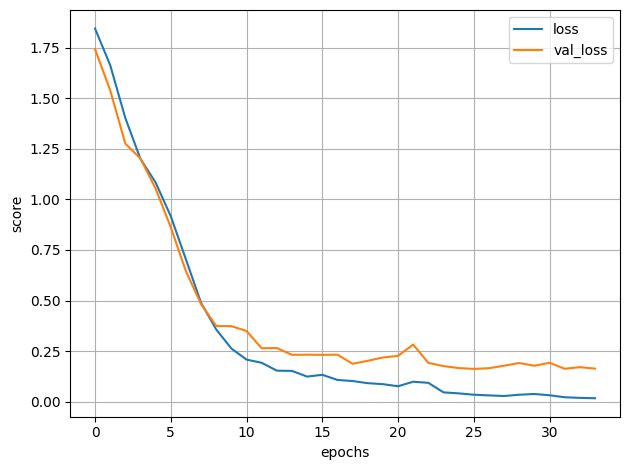

In [ ]:
import pandas as pd

data_history = pd.DataFrame(history.history)
data_history.to_csv('image_to_text_history.csv')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epochs')
plt.ylabel('score')
plt.legend(loc="best")


plt.grid(True)
plt.tight_layout()
plt.show()